我们实现 dropout_layer 函数，该函数以dropout的概率丢弃张量输入X中的元素

整个函数通过生成一个随机的掩码来决定哪些神经元在当前批次的训练中被“关闭”。为了保证模型输出的平均值不变，它同时对未关闭的神经元的输出进行了放大。这个过程在每次前向传播时都会随机进行，迫使网络中的每个神经元都不能过分依赖特定的其他神经元，从而增强了模型的鲁棒性，有效防止过拟合。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
    return mask * X / (1.0 - dropout)

1. assert 0 <= dropout <= 1
这行代码使用 assert 语句来断言（assert）dropout 参数的值必须在 0 到 1 之间（包含 0 和 1）。如果 dropout 的值不满足这个条件，程序会立即终止并报错。这是一种防御性编程，用于确保函数的输入是有效的。

2. if dropout == 1:
如果 dropout 的值为 1，这意味着要丢弃所有神经元。torch.zeros_like(X) 会创建一个与输入张量 X 形状相同、但所有元素都为 0 的新张量，并将其返回。

3. if dropout == 0:
如果 dropout 的值为 0，这意味着不丢弃任何神经元。函数会直接返回原始输入张量 X。

4. mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
这是实现 Dropout 的核心步骤。

torch.Tensor(X.shape): 创建一个与输入张量 X 形状相同的新张量。

.uniform_(0, 1): 对这个新张量中的每个元素进行原地（in-place）填充，使其均匀分布在 0 到 1 之间。

> dropout: 这是一个逐元素比较的操作。它会生成一个布尔张量（True 或 False），True 表示对应的随机数大于 dropout 值，False 则表示小于或等于。

.float(): 将布尔张量转换为浮点张量，其中 True 变为 1.0，False 变为 0.0。

mask: 最终得到的 mask 张量是一个由 0.0 和 1.0 组成的“掩码”，1.0 表示保留该神经元，0.0 表示丢弃该神经元。例如，如果 dropout 是 0.5，那么 mask 中的 1.0 和 0.0 的比例大约各占一半。

5. return mask * X / (1.0 - dropout)
这是应用掩码并进行缩放的最后一步。

mask * X: 将掩码 mask 与输入张量 X 进行逐元素相乘。这会将 mask 中为 0 的位置对应的 X 中的元素也变为 0，从而实现“丢弃”神经元的效果。

/ (1.0 - dropout): 对结果进行缩放。

为什么需要缩放？ 在训练时，一部分神经元被随机丢弃，导致输出的激活值总和变小。为了保持训练和测试阶段输出的期望值一致，我们需要对未被丢弃的神经元的输出进行放大。

例如，如果 dropout 是 0.5，那么未被丢弃的神经元是原来的一半，它们的输出值需要乘以 1/(1−0.5)=2 来弥补被丢弃的那一半。

这种缩放方法被称为倒置丢弃法（Inverted Dropout），它使得在测试时无需进行任何额外的操作，可以直接使用所有神经元。

In [2]:
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  6.,  0., 10., 12.,  0.],
        [16., 18., 20.,  0., 24.,  0., 28.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元

In [3]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

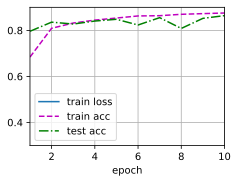

In [4]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

简洁实现

In [5]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
                    nn.Dropout(dropout1), nn.Linear(256, 256), nn.ReLU(),
                    nn.Dropout(dropout2), nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

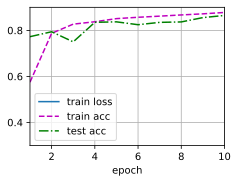

In [6]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)